# Exemplos de problemas de classificação

In [37]:
# estrutura de dados
import pandas as pd
import numpy as np

# visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# metricas
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# treino teste
from sklearn.model_selection import train_test_split

# modelo
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import ExtraTreeClassifier

# tunagem
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# teste estatística
from scipy.stats import ttest_ind
import scipy.stats as ss

## Prevendo a qualidade do vinho

https://www.kaggle.com/datasets/rajyellow46/wine-quality

### Classificação supervisionada

In [38]:
# lendo os dados
df = pd.read_csv('../datasets/vinho/winequalityN.csv')
# preenchendo nulos com a média
df = df.fillna(df.mean(numeric_only=True))
# dummies em type
type_dummies = pd.get_dummies(df['type'],prefix='type',dtype=int)
df = pd.concat([df, type_dummies],axis=1)
df.drop('type',inplace=True,axis=1)
# separando variáveis preditoras e de interesse
X = df.drop('quality', axis=1)
y = df['quality']
# separando em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)
# treinando Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

Qual variável é mais importante para a qualidade do vinho baseado em nosso modelo?

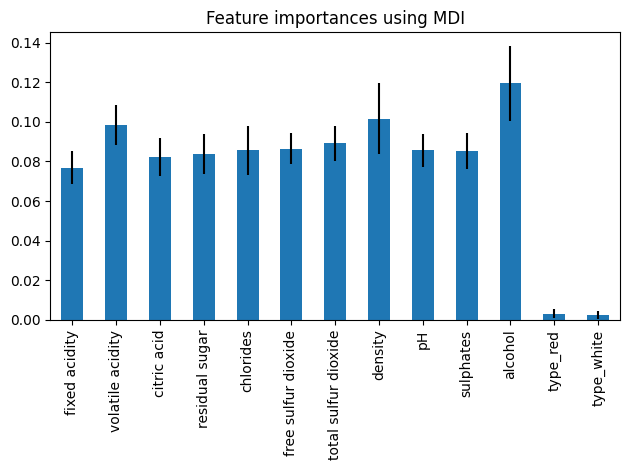

In [39]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=df.drop('quality',axis=1).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
fig.tight_layout()

Quais métricas melhor avaliam o modelo?

In [40]:
# Matriz de confusão
y_pred = model.predict(X_test)
cm = ConfusionMatrix(actual_vector=y_test.values, predict_vector=y_pred)
cm.print_matrix()

Predict   3         4         5         6         7         8         
Actual
3         0         0         3         3         0         0         

4         0         6         40        15        2         0         

5         0         3         465       169       3         0         

6         0         1         150       669       41        1         

7         0         0         12        148       163       2         

8         0         0         1         16        22        15        




In [41]:
# Métricas da matriz de confusão
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           3       1.00      0.00      0.00         6
           4       0.60      0.10      0.16        63
           5       0.69      0.73      0.71       640
           6       0.66      0.78      0.71       862
           7       0.71      0.50      0.59       325
           8       0.83      0.28      0.42        54

    accuracy                           0.68      1950
   macro avg       0.75      0.40      0.43      1950
weighted avg       0.68      0.68      0.66      1950



https://medium.com/@mateuspdua/machine-learning-m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-acur%C3%A1cia-precis%C3%A3o-e-recall-d44c72307959

In [12]:
# observe que a classe de qualidade 9 foi ignorada
# isso ocorreu por esta estar presente apenas no treino
# por isso a importância de extratificação de dados
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [43]:
# Fazendo uma classificação
data = pd.DataFrame({
    'fixed acidity': [7.2], 
    'volatile acidity': [0.3], 
    'citric acid': [0.3], 
    'residual sugar': [5.4],
    'chlorides': [0.05], 
    'free sulfur dioxide': [30.5], 
    'total sulfur dioxide': [115], 
    'density':[0.994],
    'pH': [3.2], 
    'sulphates': [0.5], 
    'alcohol': [10.5], 
    'type_red': [0], 
    'type_white': [1]
})
model.predict(data)

array([6], dtype=int64)

## Comparando score no treino e no teste

In [44]:
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 1.0
Score Teste: 0.6758974358974359


O modelo se ajustou muito ao treino, mas não ao teste! Isso é chamado de sobreajuste (overfitting). Vamos treinar outro modelo.

In [45]:
# treinando Gaussian Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)

GaussianNB()

In [46]:
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 0.3191115020892896
Score Teste: 0.33076923076923076


O modelo se ajustou pouco ao treino. Isso é chamado de subajuste (underfitting). Vamos treinar outro modelo.

In [47]:
# Treinando modelo dos K vizinhos mais próximos
model = KNeighborsClassifier()
model.fit(X_train, y_train)

KNeighborsClassifier()

In [48]:
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 0.6347042005718055
Score Teste: 0.4635897435897436


Tivemos aqui outro overfitting, mas vamos tunar o número de vizinhos.

In [49]:
score_treino = []
score_teste = []
for n_neighbors in range(1,50):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    score_treino.append(accuracy_score(y_train, model.predict(X_train)))
    score_teste.append(accuracy_score(y_test, model.predict(X_test)))

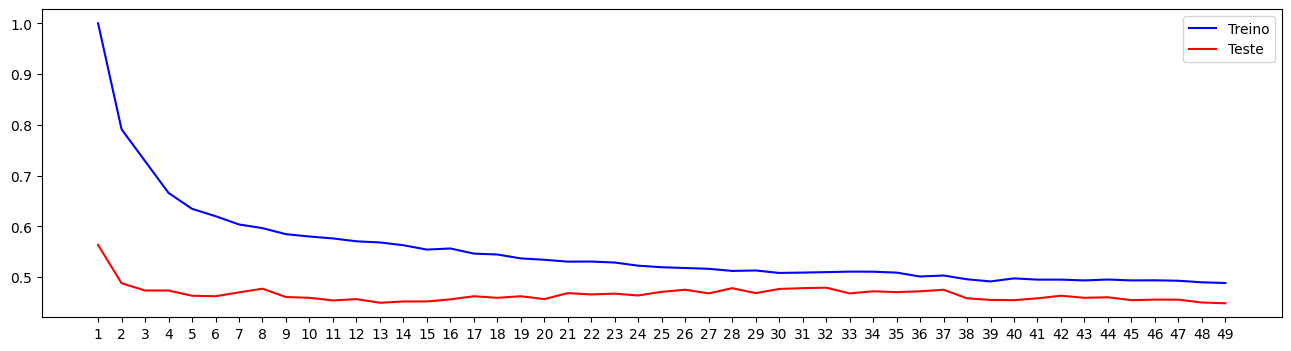

In [50]:
plt.figure(figsize=(16,4))
plt.plot(list(range(1,50)), score_treino, label="Treino", color="b")
plt.plot(list(range(1,50)), score_teste, label="Teste", color="r")
plt.legend()
plt.xticks(list(range(1,50)))
plt.show()

Por padrão, sem tunagem o número de vizinhos é 5. Mas observe que é possível obter um score maior no teste com um número menor de vizinhos. Por exemplo, com um vizinho. No entanto, ocorreu um overfitting no modelo uma vez que o score no treino é 100% e é bem maior que no teste.

In [51]:
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train, y_train)
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 1.0
Score Teste: 0.5635897435897436


O parâmetro "mais honesto" k=32 ou k=37, neste caso optamos pelo menor k por eficiência no modelo. Vale observar que k=1, apesar de ser overfitting, tem maior score no teste.

In [52]:
model = KNeighborsClassifier(n_neighbors=32)
model.fit(X_train, y_train)
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 0.5100065977567627
Score Teste: 0.4794871794871795


In [53]:
model = KNeighborsClassifier(n_neighbors=37)
model.fit(X_train, y_train)
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 0.503408840994062
Score Teste: 0.4753846153846154


Vamos turnar mais hiperparâmetros do KNN, mas isso pode demorar, então usaremos uma biblioteca própria para tunagem.

In [54]:
# definiremos o espaço de busca dos parâmetros
# http://hyperopt.github.io/hyperopt/getting-started/search_spaces/
space = {
    'n_neighbors': hp.uniform("n_neighbors", 1, 40), # número de vizinhos de 1 a 40
    'metric': 'minkowski', # métrica de minkowski
    'p': hp.uniform('p', 1, 4), # minkowski com p variando de 1 a 4
    'weights': hp.choice('weights', ["uniform", "distance"]) # pesos uniforms ou por distância
}

In [24]:
# definiremos a função objetivo a ser minimizada
def objective(space):
    
    clf = KNeighborsClassifier(
        n_neighbors = int(space['n_neighbors']),
        metric = space['metric'],
        p = int(space['p']),
        weights = space['weights']
    )
    X_traint, X_testt, y_traint, y_testt = train_test_split(X_train, y_train ,test_size=0.2,random_state=42)
    
    clf.fit(
        X_traint, y_traint,
    )
    y_pred = clf.predict(X_testt)
    acc = accuracy_score(y_testt, y_pred)
    
    return {'loss': -acc, 'status': STATUS_OK }

In [55]:
# faremos 300 buscas
trials = Trials()
best_hyperparams = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 300,
    trials = trials)

100%|██████████████████████████████████| 300/300 [00:07<00:00, 38.48trial/s, best loss: -0.5912087912087912]


In [56]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'n_neighbors': 14.409238805355146, 'p': 1.2223589034395161, 'weights': 1}


O resultado da tunagem é que o número de vizinhos deve ser 14, peso por distância e a métrica de Manhattan. Vamos ver no teste.

In [57]:
model = KNeighborsClassifier(
    n_neighbors=14,
    p=1,
    metric='minkowski',
    weights='distance'
)
model.fit(X_train, y_train)
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 1.0
Score Teste: 0.5964102564102564


Apesar de no teste termos o melhor dos resultados, o modelo se ajustou muito no treino, havendo um overfitting.

Ao executar o mesmo treino e avaliação acima obtemos o mesmo resutado:

In [58]:
model = KNeighborsClassifier(
    n_neighbors=14,
    p=1,
    metric='minkowski',
    weights='distance'
)
model.fit(X_train, y_train)
print("Score Treino:", accuracy_score(y_train, model.predict(X_train)))
print("Score Teste:", accuracy_score(y_test, model.predict(X_test)))

Score Treino: 1.0
Score Teste: 0.5964102564102564


Isso ocorre devido ao fato de que o processo de treinamento do KNN é determinístico. Existem modelos que o processo é estocástico, isto é, o resultado a cada treinamento pode dar diferente, como é o caso do Random Forest:

In [59]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Score Teste 1:", accuracy_score(y_test, model.predict(X_test)))
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Score Teste 2:", accuracy_score(y_test, model.predict(X_test)))
model = RandomForestClassifier()
model.fit(X_train, y_train)
print("Score Teste 3:", accuracy_score(y_test, model.predict(X_test)))

Score Teste 1: 0.6753846153846154
Score Teste 2: 0.6651282051282051
Score Teste 3: 0.6717948717948717


Outro exemplo de modelo estocástico é o Gradient Boosting:

In [30]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print("Score Teste 1:", accuracy_score(y_test, model.predict(X_test)))
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print("Score Teste 2:", accuracy_score(y_test, model.predict(X_test)))
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
print("Score Teste 3:", accuracy_score(y_test, model.predict(X_test)))

Score Teste 1: 0.5912820512820512
Score Teste 2: 0.5917948717948718
Score Teste 3: 0.5917948717948718


Neste caso, comparar tais modelos pode ser um problema, uma vez que os resultados no teste são variáveis aleatórias. A maneira correta é fazer um teste de hipótese.

<h1 style="color:red">As duas células abaixo vão demorar, mude 100 para 20</h1>

In [80]:
random_forest_scores = []
for _ in range(100):
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    random_forest_scores.append(accuracy_score(y_test, model.predict(X_test)))

In [81]:
gradient_boosting_scores = []
for _ in range(100):
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)
    gradient_boosting_scores.append(accuracy_score(y_test, model.predict(X_test)))

In [83]:
results_df = pd.DataFrame({
    "GB": gradient_boosting_scores,
    "RF": random_forest_scores
})

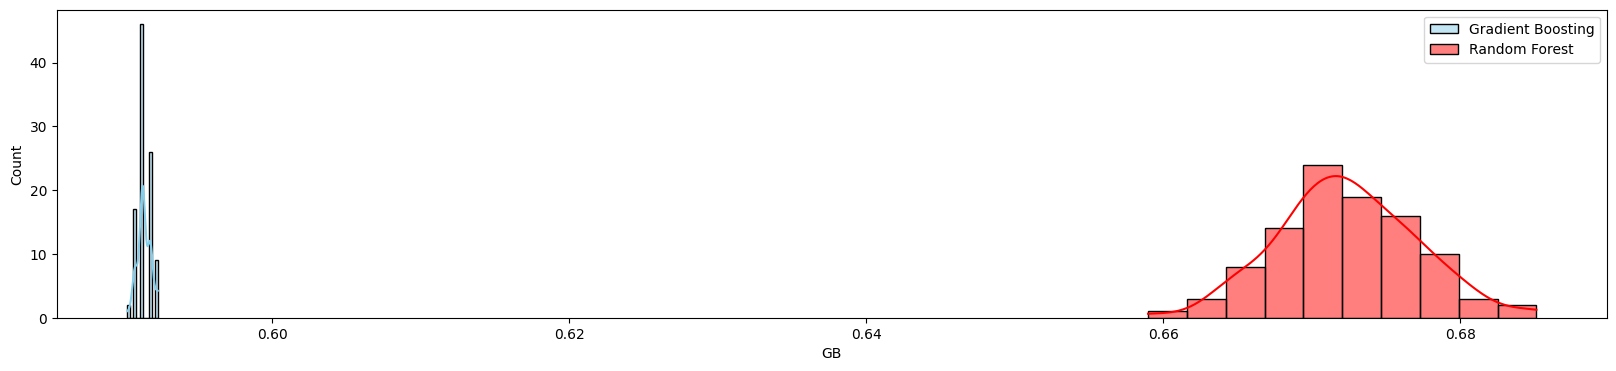

In [85]:
plt.figure(figsize=(20,4))
sns.histplot(data=results_df, x="GB", color="skyblue", label="Gradient Boosting", kde=True)
sns.histplot(data=results_df, x="RF", color="red", label="Random Forest", kde=True)
plt.legend() 
plt.show()

É óbvio que o Random Forest é melhor! Vejamos outro exemplo de comparação:

In [92]:
extra_tree_scores = []
for _ in range(100):
    model = ExtraTreeClassifier()
    model.fit(X_train, y_train)
    extra_tree_scores.append(accuracy_score(y_test, model.predict(X_test)))

In [93]:
results_df["ET"] = extra_tree_scores

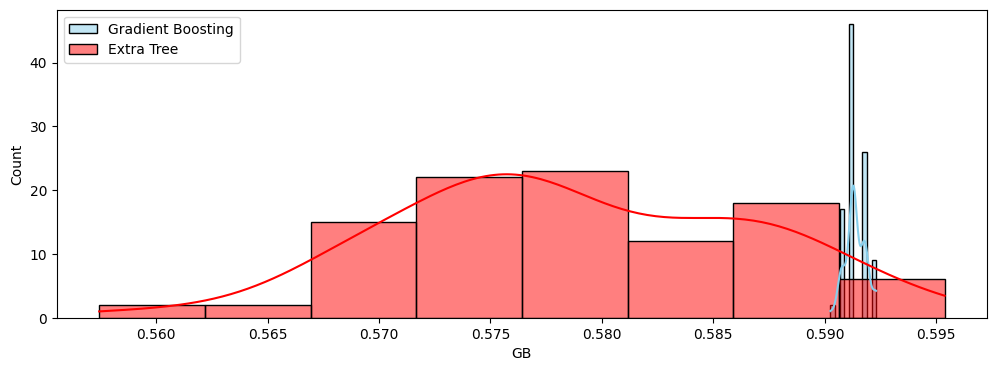

In [95]:
plt.figure(figsize=(12,4))
sns.histplot(data=results_df, x="GB", color="skyblue", label="Gradient Boosting", kde=True)
sns.histplot(data=results_df, x="ET", color="red", label="Extra Tree", kde=True)
plt.legend() 
plt.show()

E agora, qual o melhor modelo? Pode ser dizer que o Gradient Boosting tem na maioria das vezes o score mais alto, mas em algumas vezes Extra Tree ganha do maior score do Gradient Boosting. Como escolher um dos dois modelos?

In [31]:
# https://statplace.com.br/blog/qual-o-melhor-teste-para-a-comparacao-de-medias/

Vamos usar um teste estatístico de comparação de médias para duas amostras independentes supondo que as duas distribuições de erro são normais.

Hipótese Nula (H0): média das acurácias do GB = média das acurácias do ET (Mgb = Met)

Hipótese Alternativa (H1): média das acurácias do GB ≠ média das acurácias do ET (Mgb ≠ Met)

Nível alfa = 0.05

In [102]:
stat, p = ttest_ind(results_df["ET"], results_df["GB"])

print(f'T-statistic: {stat}')
print(f'P-value: {p}')

T-statistic: -16.172041167693735
P-value: 4.722212838777404e-38


Podemos REJEITAR a Hipótese nula, de que não há diferença nas médias dessas duas amostras

Vejamos as acurácias por meio de boxplots.

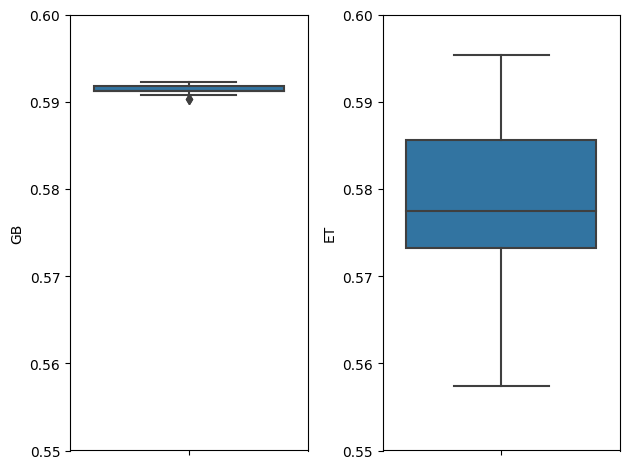

In [107]:
plt.subplot(1,2,1)
sns.boxplot(data=results_df, y="GB")
plt.ylim([0.55,0.6])
plt.subplot(1,2,2)
sns.boxplot(data=results_df, y="ET")
plt.ylim([0.55,0.6])
plt.tight_layout()
plt.show()

In [32]:
# https://cienciadedadosuff.github.io/cursos/notebooks/caderno-6.html

Vamos usar um teste estatístico de comparação de médias unilateral para duas amostras independentes supondo que as duas distribuições de erro são normais.

Antes devemos fazer um teste de comparação entre as variâncias.

In [111]:
def rvar_test(x1, x2, value, alternative):
    stattest = (np.var(x1)/np.var(x2))/value
    
    if alternative == 'smaller':
        pvalor = ss.f.cdf(stattest, len(x1) - 1, len(x2) - 1)
    elif alternative == 'larger':
        pvalor = 1 - ss.f.cdf(stattest, len(x1) - 1, len(x2) - 1)
    elif alternative == 'two-sided':
        pvalor = 2*ss.f.cdf(stattest, len(x1) - 1, len(x2) - 1)
        if pvalor >= 1:
            pvalor = 1
        
    print('(%.16f,%.16f)' % (stattest, pvalor)) 

In [113]:
rvar_test(
    x1 = results_df["GB"], 
    x2= results_df["ET"],
    value=1,
    alternative="larger")

(0.0034796628589532,1.0000000000000000)


"Como p-valor=1 sendo maior que o nível de significância proposto, há evidências de que as varianças são iguais. Agora aplicaremos o teste de comparação de médias considerando as variâncias iguais."

Agora sim! Faremos o teste para comparação de médias.

Hipótese Nula (H0): média das acurácias do GB = média das acurácias do ET (Mgb = Met)

Hipótese Alternativa (H1): média das acurácias do GB > média das acurácias do ET (Mgb ≠ Met)

Nível alfa = 0.05

In [118]:
ttest_ind(
    results_df["GB"],
    results_df["ET"], 
    alternative = 'two-sided', 
    equal_var = True)

Ttest_indResult(statistic=16.172041167693735, pvalue=4.722212838777404e-38)

Como o p-valor é menor que o nível de significância proposto, há evidências para rejeitar a hipótese nula e aceitar a alternativa. Logo podemos assumir quem em média os resultados do Gradient Boosting são melhores que os resultados do Extra Tree.

# Atividade avaliativa 3

## Problema de classificação supervisionada.

https://www.kaggle.com/competitions/playground-series-s3e17

Suponha que seu score é S:

- Se S < 0.61, seus pontos seriam (1 - (S - 0.6)/0.6) * 4
- Se 0.61 <= S <= 0.81, seus pontos seriam proporcionais no intervalo de 4 a 7.
- Se 0.81 <= S <= 0.91, seus pontos seriam proporcionais no intervalo de 7 a 10.